# Prospecção de Dados (Data Mining) DI/FCUL - HA1

## First Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`13`

* Miguel Landum, 35019 - Hours worked on the project
* Niklas Schmitz, 62689 - Hours worked on the project
* Pol Parra, 62692 - Hours worked on the project
* Til Dietrich, 62928 - Hours worked on the project


The purpose of this Home Assignment is
* Read a Data file with a Set of Texts
* Compute similarities between texts
* Perform simple classification of texts using a Naive Bayes classifier

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**


## 1. Read the Dataset

The dataset is the file `Sentences_75Agree.txt` from the [Financial Sentiment Analysis database on Gugging Face](https://huggingface.co/datasets/financial_phrasebank)

* Read the dataset and separate them by unique documents (one document per line)
* The last word of each document is the class and it **must be removed from the document** but kept separate for use in the classification tasks below
    * classes can be `.@positive`, `.@negative`, `.@neutral`
    


In [15]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Initialize documents and class lists
documents = []
classes = []

# Open the file line by line as that should be more efficient than reading the whole file into memory with readlines() 
# and we have to use rfind for each line anyways
with open('Sentences_75Agree.txt', 'r', encoding='ISO-8859-1') as file:
    # Read line by line
    for line in file:
        # Find the class index
        class_index = line.rfind('@')

        # Split classes and document and append to respective lists
        classes.append(line[class_index:].strip())
        documents.append(line[:class_index].strip())

print(len(documents))
print(len(classes))
documents[:5], classes[:5]

3453
3453


(['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .',
  "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .',
  'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .'],
 ['@neutral', '@positive', '@positive', '@positive', '@positive'])

## 2. Compute similarities between texts

* Compute the TF.IDF of all words in texts
* compute the average similarity beween texts
* Plot the document similarity distribution (suggestion use [boxplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html) or [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) or  [histograms with density](https://matplotlib.org/stable/gallery/statistics/histogram_features.html))
* Comment your results


In [2]:
### Add supporting functions here
from math import log2
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### methods for easy code cleaning
def basic_word_tokenizer(text):
    return text.split()

def remove_accents(s):
    nfkd_form = unicodedata.normalize('NFKD', s)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

# Adjusted function to remove stuff
def remove_stuff(s):
    # Remove 's and '
    s = s.replace("'s", "").replace("'", "")
    
    # Remove other unwanted characters
    for c in "\\\t0123456789Ææœ—‘’\ufeff{|}“”.,()$£%&[]?@#!=;*+–\"ǁ:<>`":
        s = s.replace(c, "")
    
    # Replace hyphens with spaces
    s = s.replace("-", " ")
    
    return s


#### methods to extract words from documents
def get_words_from_corpus(corpus):
    words_texts=[]
    for i,text in enumerate(corpus):
        text=text.strip().lower()
        text=remove_accents(text)
        text=remove_stuff(text)
        text=text.lower()
        words = basic_word_tokenizer(text)
        words_texts.append(words)
    return words_texts

def calc_all_words(words_text_sets):
    all_words=set()
    for words in words_text_sets: all_words |= words
    return all_words

def word_counter(words):
    #1. get uniques
    unique_words=set(words)
    #2. make a dictionary for counting
    D=dict(zip(unique_words, [0]*len(unique_words)))
    #3. count all
    for w in words: D[w]+=1
    return D


#### methods to calculate TFIDF
def TF(word_counts):
    #get the counts
    counts  = word_counts.values()
    if len(counts)==0: return {}
    the_max = max(counts)   #compute the maximum
    #return a dictionary that for each word returns the ratio of wc/max_wc
    return dict(zip(word_counts.keys(), [c/the_max for c in counts]))

def calc_tfs(words_texts):
    all_tfs=[]
    for words in words_texts:
        wcounts = word_counter(words)
        all_tfs.append(TF(wcounts))
    return all_tfs

def IDF(all_words, doc_word_counts):
    #first initialize a new dictionary with one entry for each word
    D=dict(zip(all_words, [0]*len(all_words)))
    N=len(doc_word_counts)
    for doc in doc_word_counts:
        for word in doc: D[word]+=1
    return {w: log2(N/D[w]) for w in D}


#### methods for computing similarities
def cosine_similarity_tfidf(idx1, idx2, words_text_sets, all_tfs, idfs):
    text1= words_text_sets[idx1]
    text2= words_text_sets[idx2]
    tfs1=all_tfs[idx1]
    tfs2=all_tfs[idx2]

    common_words = text1 & text2
    if len(common_words)==0: return 0.0
    common_tfidfs = [tfs1[w]*tfs2[w]*idfs[w]*idfs[w] for w in common_words]

    #squared tfidfs
    tfidfs2_1=np.array([tfs1[w]*idfs[w] for w in text1])**2
    tfidfs2_2=np.array([tfs2[w]*idfs[w] for w in text2])**2

    return sum(common_tfidfs)/(np.sqrt(tfidfs2_1.sum())*np.sqrt(tfidfs2_2.sum()))

def text_similarities2(words_text_sets, all_tfs, idfs):
    N=len(words_text_sets)
    sims=[]
    for i in range(N-1):
        for j in range(i+1, N):
            sim = cosine_similarity_tfidf(i,j, words_text_sets, all_tfs, idfs)
            sims.append((sim, (i,j)))
    return sims

3453
7246

1. Document:
   according - Counts:  1; TF:  0.3333 IDF:  5.5248 -> TFIDF:  1.8416
          to - Counts:  3; TF:  1.0000 IDF:  1.2993 -> TFIDF:  1.2993
        gran - Counts:  1; TF:  0.3333 IDF: 10.7536 -> TFIDF:  3.5845
         the - Counts:  2; TF:  0.6667 IDF:  0.5027 -> TFIDF:  0.3352
     company - Counts:  2; TF:  0.6667 IDF:  2.6662 -> TFIDF:  1.7774


2. Document:
        with - Counts:  1; TF:  0.2000 IDF:  3.3786 -> TFIDF:  0.6757
         the - Counts:  5; TF:  1.0000 IDF:  0.5027 -> TFIDF:  0.5027
         new - Counts:  1; TF:  0.2000 IDF:  4.4590 -> TFIDF:  0.8918
  production - Counts:  2; TF:  0.4000 IDF:  5.6662 -> TFIDF:  2.2665
       plant - Counts:  1; TF:  0.2000 IDF:  5.7313 -> TFIDF:  1.1463


3. Document:
         for - Counts:  2; TF:  0.6667 IDF:  2.2578 -> TFIDF:  1.5052
         the - Counts:  2; TF:  0.6667 IDF:  0.5027 -> TFIDF:  0.3352
        last - Counts:  1; TF:  0.3333 IDF:  5.7536 -> TFIDF:  1.9179
     quarter - Counts:  1; TF:  0.33

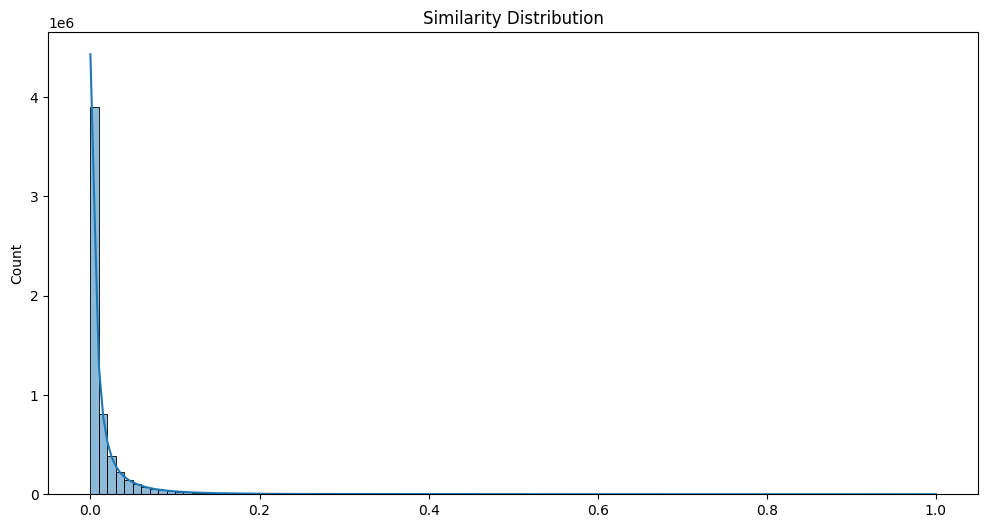

In [3]:
### Add processing code here
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Compute the TF.IDF of all words in texts
# splitting documents into words
words_texts = get_words_from_corpus(documents)

words_text_sets = [set(words) for words in words_texts]
all_words = calc_all_words(words_text_sets)

all_tfs = calc_tfs(words_texts)

all_idfs = IDF(all_words, words_text_sets)

print(len(all_tfs))
print(len(all_idfs))

print("\n1. Document:")
text=words_texts[0]
wcounts =word_counter(text)
tfs=TF(wcounts)

for word in text[:5]:
    print("%12s - Counts:%3d; TF: %7.4f IDF: %7.4f -> TFIDF: %7.4f" % (word, wcounts[word], 
                                                                       tfs[word], all_idfs[word],
                                                                       tfs[word]*all_idfs[word]))
print("\n\n2. Document:")
text=words_texts[1]
wcounts =word_counter(text)
tfs=TF(wcounts)

for word in text[:5]:
    print("%12s - Counts:%3d; TF: %7.4f IDF: %7.4f -> TFIDF: %7.4f" % (word, wcounts[word], 
                                                                       tfs[word], all_idfs[word],
                                                                       tfs[word]*all_idfs[word]))
print("\n\n3. Document:")
text=words_texts[2]
wcounts =word_counter(text)
tfs=TF(wcounts)

for word in text[:5]:
    print("%12s - Counts:%3d; TF: %7.4f IDF: %7.4f -> TFIDF: %7.4f" % (word, wcounts[word], 
                                                                       tfs[word], all_idfs[word],
                                                                       tfs[word]*all_idfs[word]))
    
#### 2. compute the average similarity beween texts:
t1=time()
sims = text_similarities2(words_text_sets, all_tfs, all_idfs)
t2=time()
print("Similarity search execution time --> %8.4f seconds" % (t2-t1)) 

sims = sorted(sims, reverse=True) # sort in descending order
# for J, text_pair in sims[:5]: 
#    print( "%s has similarity: %7.4f" % (text_pair, J))


#### 3. Plot the document similarity distribution
# Make a histogram with density function of the similarities
plt.figure(figsize=(12, 6))
sns.histplot([s[0] for s in sims], kde=True, bins=100)
plt.title("Similarity Distribution")
plt.show()

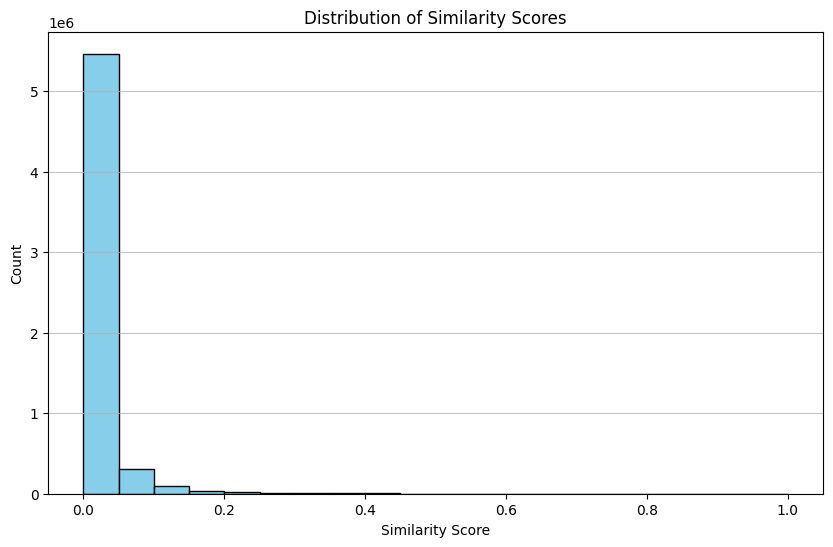

Length of similarity scores: 5959878
Similarity scores with values OUTSIDE 0 and 0.2: 58731


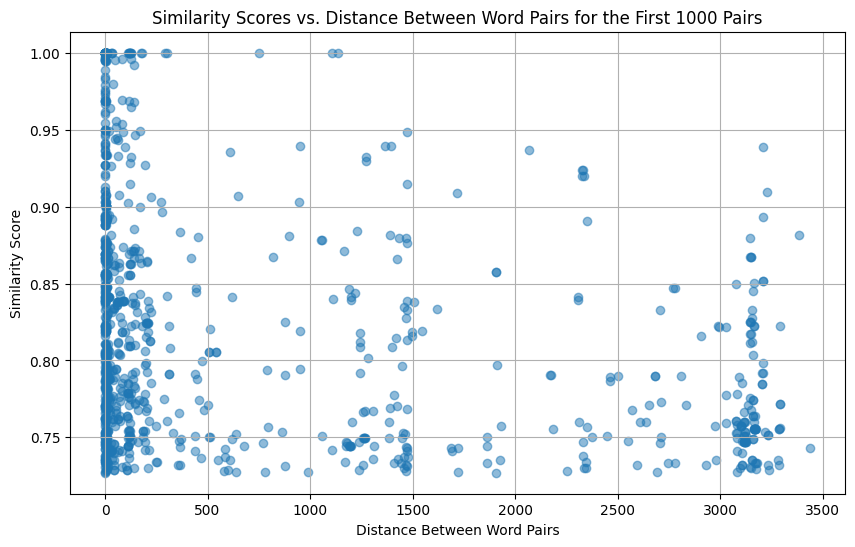

In [4]:
# In our first histogram we want to show the distribution of the similarity scores.
similarity_scores = [score for score, _ in sims]

# Creating a histogram for similarity scores
plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.title('Distribution of Similarity Scores')
plt.grid(axis='y', alpha=0.75)

plt.show()
# Findings from first plot: most of the pairs have a similarity score of almost 0
values_in_range = [value for value in similarity_scores if 0 <= value <= 0.2]
print(f"Length of similarity scores: {len(similarity_scores)}")
print(f"Similarity scores with values OUTSIDE 0 and 0.2: {len(similarity_scores) - len(values_in_range)}")
# looking deeper into the numbers this finding is correct

# TODO overthink second plot and interpret findings more
# In our second histogram we want to show the distribution of the distance between word pairs.
distances_first_1000 = [abs(pair[1][1] - pair[1][0]) for pair in sims[:1001]]
similarity_scores_first_1000 = [score for score, _ in sims[:1001]]

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distances_first_1000, similarity_scores_first_1000, alpha=0.5)

plt.xlabel('Distance Between Word Pairs')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores vs. Distance Between Word Pairs for the First 1000 Pairs')
plt.grid(True)

plt.show()

### Your short analysis here
The analysis has been performed in a dataset composed of 3453 documents and 7246 unique words. The reason why they are different length is that the tfs is only related to the current document. Therefore in all_tfs the documents are split into single entries. On the contrary for IDFS its scope is for all documents, therefore it can be easily displayed as every unique word in the documents is taking into account instead of the occurencens of words within only one document

Because of this it is not possible to print out the TFIDF for each single word, as the tfs is only related to the scope of one document, which confused us in the beginning. Hence, we calculate the TFIDF for the first 3 documents and print out the first 5 words of each document

#### TF.IDF Analysis


#### Similarity Distribution
A vast majority of document pairs have very low similarity scores, close to 0, which confirms our above comments, tfs are only related to the current document. 
Very few document pairs have high similarity scores (toward the right end of the x-axis), indicating that it is pretty rare to find documents with high similarity. 

#### Similarity Score 
For the second plot we calculated and displayed the distances between word pairs.
With that we wanted to see if similar meaning are often used in very short distance to each other and how many pairs have a high similarity but are far away from each other.

Out of all the similarity scores computed, 58731 of them had values that were outside the range of 0 to 0.2, which implies that most of the computed similarity scores were very low (at or below 0.2), suggesting that the majority of document pairs had little in common.

To support this results we made a sckatter plot comparingOn the scatter plot we see that most of the points are clustered at the very beginning of the x-axis, confirming that many of the word pairs with high similarity are found close to each other within the documents. 
It is interesting to see how as the distance between word pairs increases, the similarity scores seem to spread out more, hence the similarity score gets reduced. At the same time, there are fewer pairs with high similarity scores. Our assumption once seing this results is that the chances of finding highly similar word pairs decrease as the distance increases.

Finally, there are significant number of pairs with high similarity "close to 1.0" regardless of the distance. This make us think that there are commomn phrases used acoross the documents. 

## 3. Make a Naive Bayes Classifier 

* Split dataset randomly into training and testing (20% for testing)
* Train a Naive Bayes Model and do some sensitivity analyis on the hyperparameters 
* Evaluate your results with the testing set


In [25]:
### Add supporting functions here
# Imports
from random import sample, shuffle
from sklearn.metrics import confusion_matrix, classification_report


# Function to calculate priors
def calc_prior_counts(labels):
    yv, yc=np.unique(labels, return_counts=True)
    priors=np.ones(len(yv))
    priors[yv]=yc
    return priors

# We already have calc_all_words function from above

# Function to calculate initial likelihoods
def init_likelihood_counts(docs_words, n_labels):
    all_words=calc_all_words(docs_words)
    L_hoods={}
    for w in all_words:
        L_hoods[w]=np.zeros(n_labels)
    return L_hoods

# Function for updating likelihoods
def update_likelihood_counts(L_hoods, words, label):
    for word in words: 
        L_hoods[word][label]+=1

# Function for calculating likelihoods
def calc_likelihood_counts(docs_words, labels):
    n_labels = len(np.unique(labels)) # numpy should be faster than the python built-in set
    L_hoods = init_likelihood_counts(docs_words, n_labels)
    for i, words in enumerate(docs_words): 
        update_likelihood_counts(L_hoods, words, labels[i])
    return L_hoods

# Function to classify a new document using the Naive Bayes classifier
def classify_new_document(words, priors, L_hoods, alpha=0):
    res=priors/priors.sum()
    alpha_vec=np.ones(len(res))*alpha
    for word in words:
        if word in L_hoods: 
            res*=(L_hoods[word]/L_hoods[word].sum() + alpha_vec)
    return res/res.sum()

# Function for train test split -> the more efficient one of the two from the TP
def make_train_test(X, y, r=0.25 ):
    N=len(X)
    D=list(range(N))
    shuffle(D)
    train_set_X = [X[i] for i in D[int(N*r):]]
    train_set_y = [y[i] for i in D[int(N*r):]]
    test_set_X = [X[i] for i in D[:int(N*r)]]
    test_set_y = [y[i] for i in D[:int(N*r)]]
    return train_set_X, train_set_y, test_set_X, test_set_y

# Function to classify all documents in a list
def classify_documents(docs, priors, L_hoods, alpha=0):
    return [classify_new_document(words, priors, L_hoods, alpha).argmax(axis=0) for words in docs]

Class Priors (negative, neutral, positive): [0.12163336 0.62148856 0.25687808]


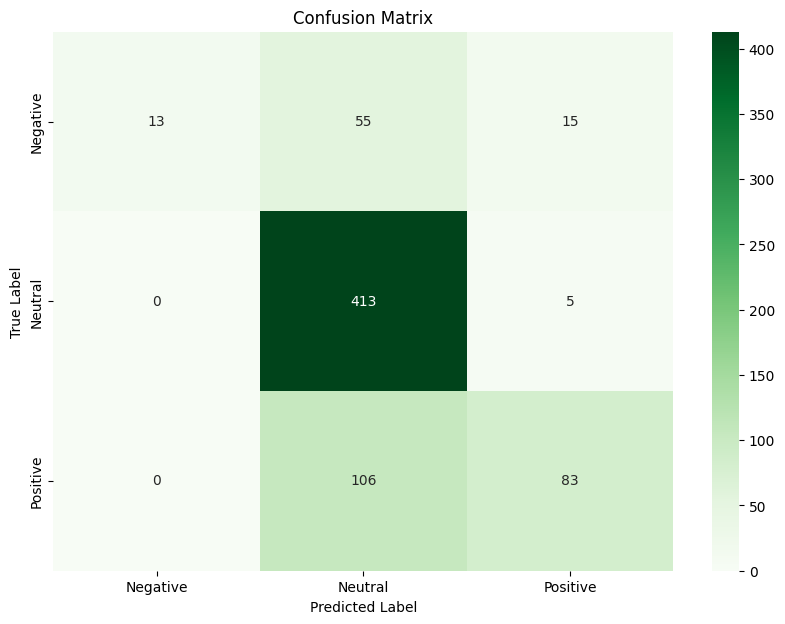

              precision    recall  f1-score   support

    Negative       1.00      0.16      0.27        83
     Neutral       0.72      0.99      0.83       418
    Positive       0.81      0.44      0.57       189

    accuracy                           0.74       690
   macro avg       0.84      0.53      0.56       690
weighted avg       0.78      0.74      0.69       690



In [35]:
### Add processing code here
# Transform classes into integers (0 -> negative, 1 -> neutral, 2 -> positive), safe class names for future use in displays
classes_int = [0 if c == '@negative' else 1 if c == '@neutral' else 2 for c in classes]
class_names = ['Negative', 'Neutral', 'Positive']

# Calculate prior counts
prior_counts = calc_prior_counts(classes_int)
print("Class Priors (negative, neutral, positive):", prior_counts/prior_counts.sum())

# Calculate likelihood counts and print them to get an idea of the structure and check if it's all fine
lhood_counts = calc_likelihood_counts(words_text_sets, classes_int)

# Make a train test split to properly test our the NB classifier
words_text_sets_train, classes_train, words_text_sets_test, classes_test = make_train_test(words_text_sets, classes_int, r=0.2)

prior_counts_train = calc_prior_counts(classes_train)
lhood_counts_train = calc_likelihood_counts(words_text_sets_train, classes_train)

classes_preds = classify_documents(words_text_sets_test, prior_counts_train, lhood_counts_train, alpha=0.0001)

# Evaluate the classifier
# Confusion matrix with heatmap visualization
conf_matrix = confusion_matrix(classes_test, classes_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
report = classification_report(classes_test, classes_preds, target_names=class_names)
print(report)

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used in a Big Data environment


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
